### First add the data functions to the path

In [8]:
import sys
import numpy as np
import pandas as pd
import xarray as xr
import copy
import seaborn as sns
from netCDF4 import Dataset
from pathlib import Path
from datetime import datetime, timedelta
notebook_dir = !pwd # Replace with !echo %cd% if using windows
library_dir = Path(notebook_dir[0]).parent.absolute()
sys.path.append(str(library_dir))
data_raw_path = library_dir / 'data' / 'raw' / 'adcp'
glider_raw_path = library_dir / 'data' / 'raw' / 'glider'
fig_path = library_dir / 'reports' / 'figures'
from src.data.adcp_mission_analysis import adcp_import_data, add_dive_averages, read_glider_nc, edgetocentre
#from src.data.beam_mapping import beam2enu, beam_from_center, caltran

def savefig(figname, extension="png"):
    plt.savefig(
        fig_path / str(figname + "." + extension),
        format=extension,
        dpi="figure",
        bbox_inches="tight",
    )

Use better plotting defaults

In [9]:
import matplotlib.pyplot as plt
from matplotlib import style
style_path = library_dir / 'src' / 'visualization' / 'presentation.mplstyle'
style.use(str(style_path))

### Load the data into Python

In [10]:
overview, mission_dict = adcp_import_data(Path('/media/callum/storage/Documents/sg637/ad2cp_nc/2018-11-20_Oban'))


/home/callum/anaconda3/envs/adcp-glider/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/media/callum/storage/Documents/adcp-glider/src/data/adcp_mission_analysis.py:457: RuntimeWarning: Mean of empty slice
  vel_referenced = vel - np.tile(np.nanmean(vel, 0) - ref_vel, (len(bin_centers), 1))


Add beam attributes. These are taken from the fifth cell (11.3 m from the glider on default settings) and averaged over each ascent/descent profile

In [11]:
beam_attrs, adcp_df = add_dive_averages(overview, mission_dict)
beam_attrs
# overview.join(beam_attrs)

,cor_beam_1,cor_beam_2,cor_beam_3,cor_beam_4,amp_beam_1,amp_beam_2,amp_beam_3,amp_beam_4,beam_miss,pitch,roll,heading,good_angle_5,good_angle_all,good_cor_5,good_cor_all
0001a,NaN,88.428571,86.714286,88.357143,NaN,36.428571,41.071429,36.571429,3.697305,-47.687855,5.717143,24.533571,14.285714,0.000000,94.761905,63.492063
0001b,94.433962,94.509434,NaN,93.943396,39.641509,40.056604,NaN,39.660377,0.749453,16.456413,6.935284,177.786591,96.226415,11.320755,99.622642,79.622642
0003a,NaN,88.058824,83.470588,87.235294,NaN,35.411765,35.764706,34.205882,3.090832,-39.786472,6.595295,143.971176,17.647059,0.000000,97.254902,58.562092
0003b,87.521739,86.304348,NaN,85.652174,34.521739,34.456522,NaN,34.217391,0.580521,20.187824,3.686956,224.902176,78.260870,30.434783,99.710145,61.835749
0004a,NaN,86.258065,89.032258,89.580645,NaN,37.532258,39.112903,38.306452,2.204289,-30.664839,8.270000,203.378387,25.806452,0.000000,99.139785,71.254480
0004b,89.861111,90.111111,NaN,89.472222,36.194444,37.833333,NaN,36.958333,0.481264,19.177498,3.727778,222.676666,77.777778,58.333333,99.259259,72.345679
0005a,NaN,91.204082,89.632653,92.163265,NaN,39.153061,38.051020,39.071429,1.674466,-26.423878,7.916326,230.124283,28.571429,24.489796,98.911565,73.242630
0005b,93.111111,94.370370,NaN,94.370370,41.981481,42.518519,NaN,42.592593,0.896939,22.537407,5.476667,234.394806,59.259259,7.407407,99.506173,79.094650
0006a,NaN,20.461538,19.250000,20.673077,NaN,29.971154,29.807692,29.817308,2.644246,-10.096348,13.082113,306.784393,0.000000,0.000000,22.051282,13.675214
0006b,1.733333,1.866667,NaN,0.866667,28.500000,28.500000,NaN,28.450000,2.363991,-0.145667,14.477999,346.375641,0.000000,0.000000,0.000000,0.000000


In [12]:
adcp_df.head()

,cast_num,pressure_ad,pitch_ad,roll_ad,heading_ad
2018-11-20 10:57:58.438199,0001a,1.201,-61.469997,8.67,12.740000
2018-11-20 10:58:13.438500,0001a,1.254,-57.879997,2.94,16.020000
2018-11-20 10:58:28.438500,0001a,1.321,-61.619999,-3.23,17.059999
2018-11-20 10:58:43.438500,0001a,1.508,-68.900002,4.06,17.719999
2018-11-20 10:58:58.438500,0001a,1.714,-66.519997,1.08,10.219999


Check that the data start when you expect. The first file in particular may have data from a previous sim dive or bench test. adapt the following cell to select the data starting on the correct day

In [ ]:
# For this dataset, need to remove the data before 23 Jan they are from 2019 benchtests and 2020 sim dives
adcp_df = adcp_df['2020-01-23':]

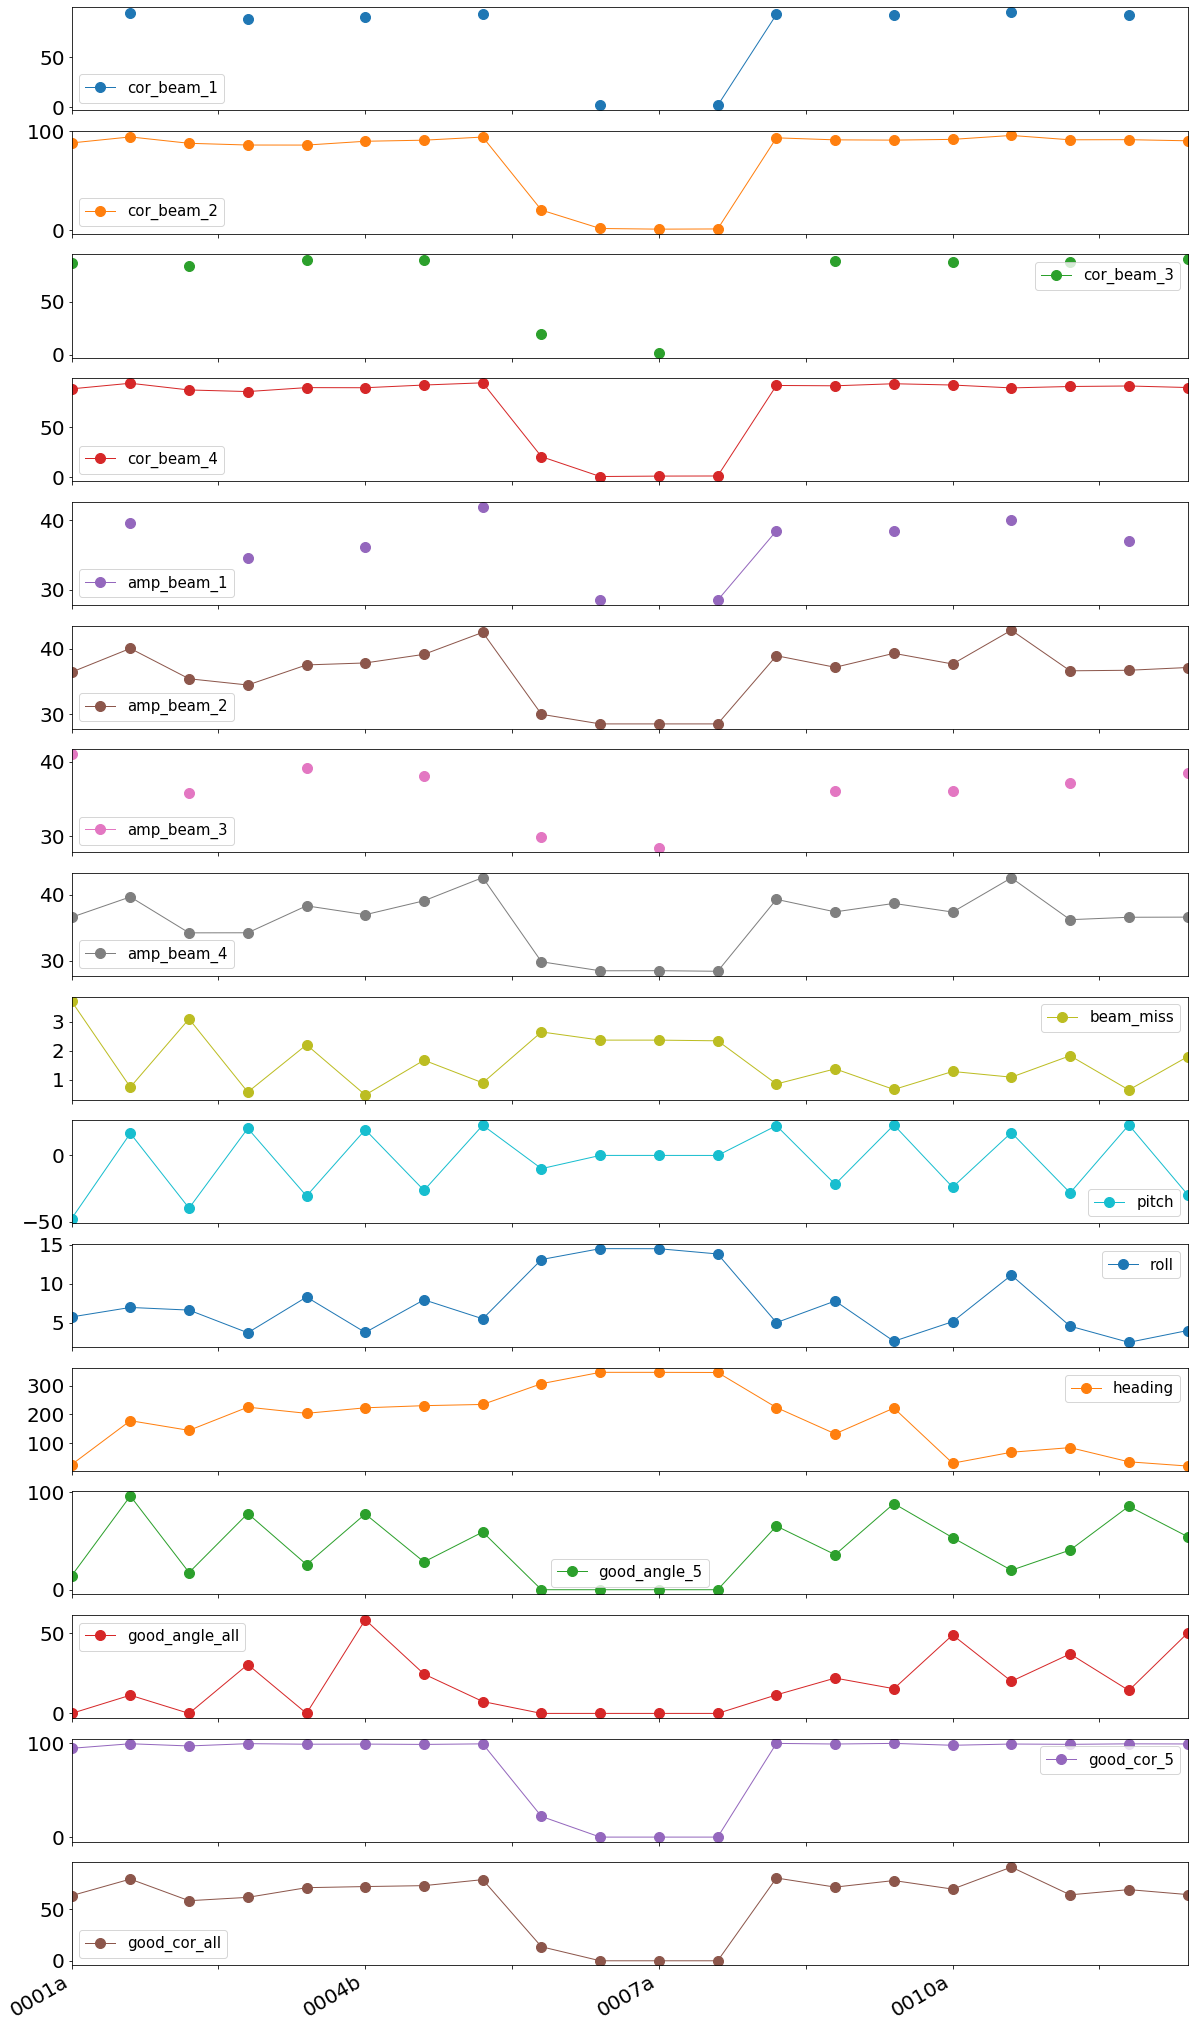

In [13]:
beam_attrs.plot(subplots=True,figsize=(20,40),marker='o');
savefig('beam_attributes')

### Print some key QC parameters from each dive limb

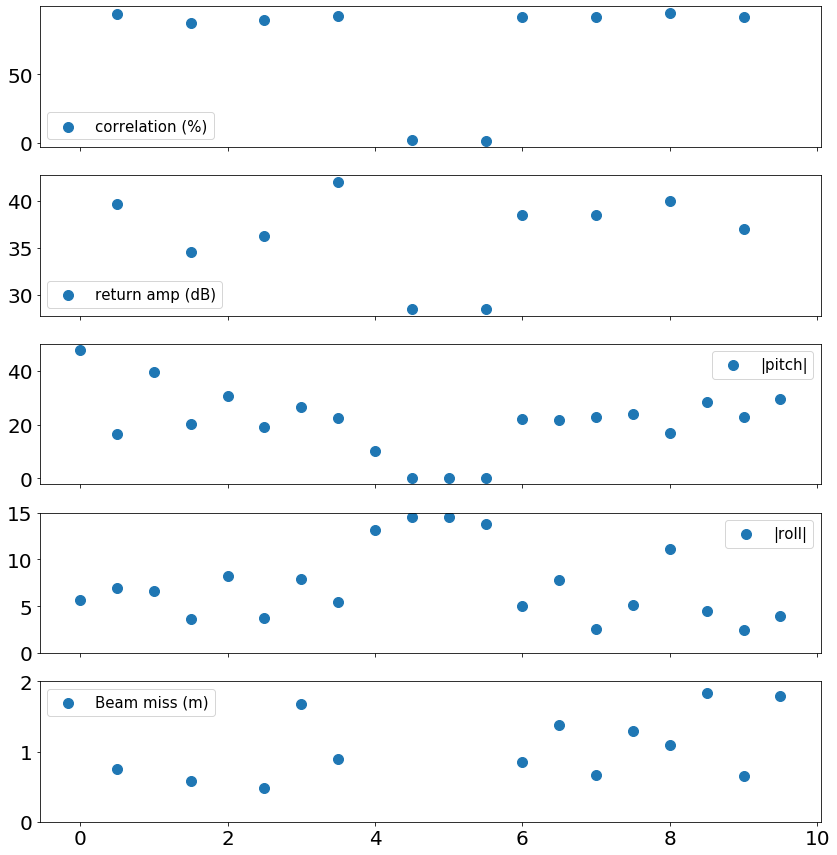

In [15]:
fig, ax = plt.subplots(5,1, sharex=True, figsize=(14,15))
ax = ax.ravel()
ax[0].scatter(np.arange(0,len(beam_attrs.index)/2,0.5), beam_attrs.cor_beam_1, label='correlation (%)')
ax[1].scatter(np.arange(0,len(beam_attrs.index)/2,0.5), beam_attrs.amp_beam_1, label='return amp (dB)')
ax[2].scatter(np.arange(0,len(beam_attrs.index)/2,0.5), np.abs(beam_attrs.pitch), label='|pitch|')
ax[3].scatter(np.arange(0,len(beam_attrs.index)/2,0.5), beam_attrs.roll, label='|roll|')
ax[3].set(ylim = [0,15])
ax[4].scatter(np.arange(0,len(beam_attrs.index)/2,0.5), beam_attrs.beam_miss, label='Beam miss (m)')
ax[4].set(ylim = [0,2])
for axi in ax:
    axi.legend()
#savefig('beam_attrs_short')

See which variables are correlated between the dive limbs

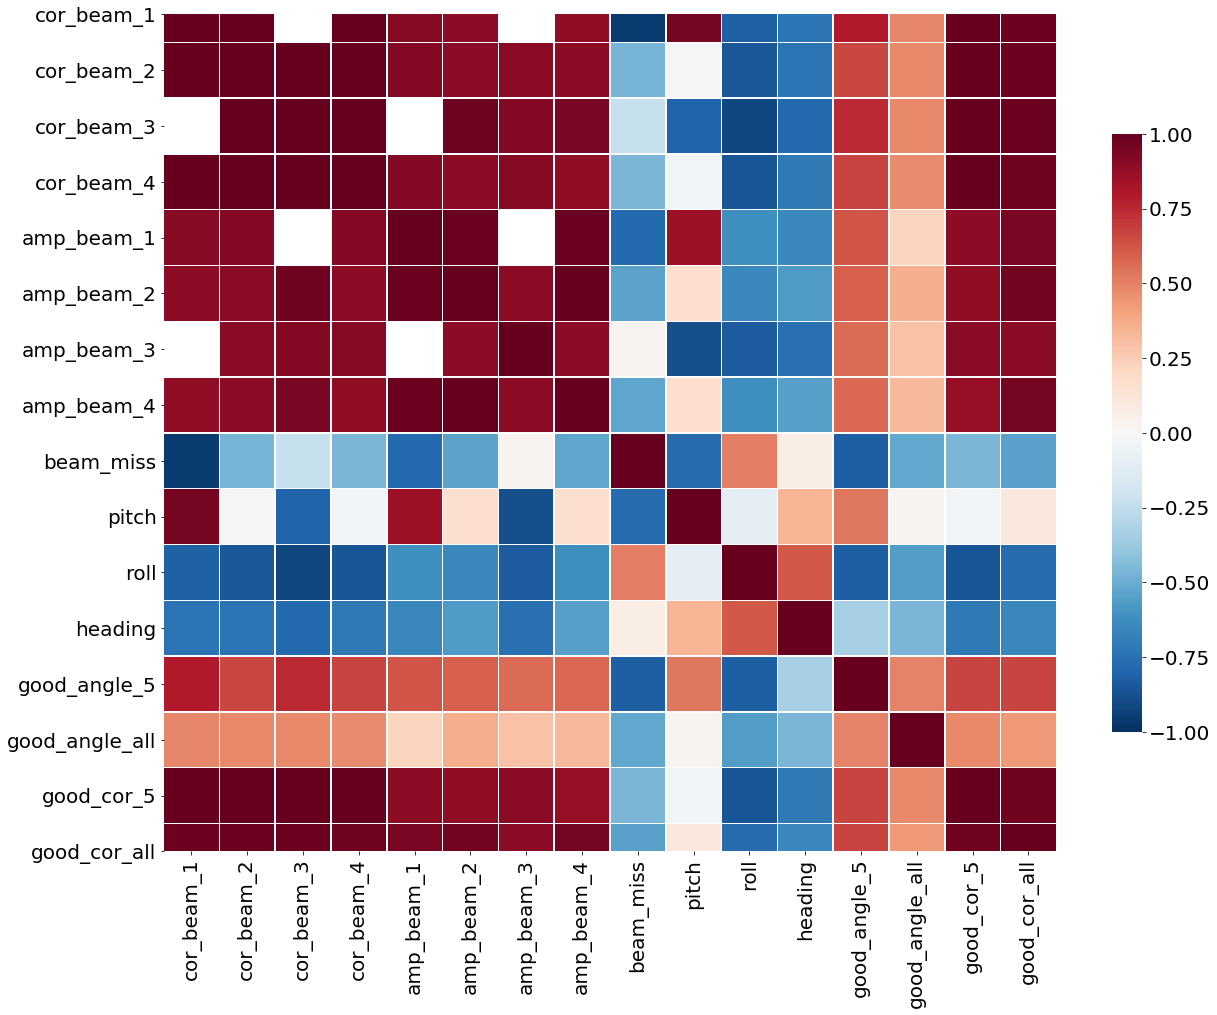

In [16]:
attr_corr = beam_attrs.corr()
mask = np.triu(np.ones_like(attr_corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(20, 22))
sns.heatmap(attr_corr, cmap='RdBu_r', vmin=-1,vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Load in glider attitude data for comparison with that from the ADCP

In [95]:
def glidertimetoneat(glider_time):
    glider_time = df.index
    time_cont_blank = np.empty(len(glider_time), dtype=datetime)
    timestamp = []
    for i in range(len(glider_time)):
        if np.isnan(glider_time[i]):
            time_cont_blank[i] = np.nan
            timestamp.append(pd.NaT)
            continue
        day = datetime.fromordinal(int(glider_time[i]))
        dayfrac = timedelta(days=glider_time[i] % 1) - timedelta(days=366)
        time_cont_blank[i] = day + dayfrac
        timestamp.append(pd.Timestamp(time_cont_blank[i]))
    return time_cont_blank, timestamp

In [100]:
def read_glider_nc(glider_netcdf_file):
    glider_nc = xr.open_dataset(glider_netcdf_file)
    df = glider_nc.to_dataframe()
    if "unnamed" in df.columns:
        df.rename(
            columns={"unnamed": "roll", "unnamed1": "pitch", "unnamed2": "heading"},
            inplace=True,
        )
    df["glider_time"], df.index = glidertimetoneat(df.index)
    return df


In [103]:
glider_df = read_glider_nc(Path('/media/callum/storage/Documents/sg637/2018-11-19_oban_round2/637_timeseries.nc'))
glider_df

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [139]:
glider_nc = xr.open_dataset(Path('/media/callum/storage/Documents/oban_round_2/2020-10-15_oban_round_2_timeseries.nc'))
df = glider_nc.to_dataframe()
if "unnamed" in df.columns:
    df.rename(
        columns={"unnamed": "roll", "unnamed1": "pitch", "unnamed2": "heading"},
        inplace=True,
    )
df["glider_time"], df.index = glidertimetoneat(df.index)
glider_df = df

In [142]:
glider_nc = xr.open_dataset(Path('/media/callum/storage/Documents/oban_round_2/2020-10-15_oban_2_timeseries.nc'))
df = glider_nc.to_dataframe()
df.head()

,DAC_u,DAC_v,abs_salinity,conductivity,cons_temp,depth,direction,dive,dive_num,lat,...,profile_num,rho,salinity,salinity_nocorr,sigma0,temp,unnamed,unnamed1,unnamed2,w_H2O
time,,,,,,,,,,,,,,,,,,,,,
737384.456925,-0.201965,-0.078004,32.003787,36.499117,11.763630,1.037225,-1.0,1.0,1.0,56.497957,...,1.0,1024.208123,31.853043,31.853043,1024.203421,11.709711,2.6,-57.8,70.7,-0.011036
737384.456988,-0.201965,-0.078004,32.004459,36.498726,11.762430,1.097064,-1.0,1.0,1.0,56.497957,...,1.0,1024.209128,31.853712,31.854586,1024.204155,11.708536,1.6,-49.2,64.3,0.001626
737384.457067,-0.201965,-0.078004,32.005878,36.495775,11.757633,1.017278,-1.0,1.0,1.0,56.497957,...,1.0,1024.210725,31.855124,31.858143,1024.206114,11.703777,2.3,-57.9,74.4,-0.001624
737384.457130,-0.201965,-0.078004,32.004881,36.494574,11.757531,1.117011,-1.0,1.0,1.0,56.497957,...,1.0,1024.210429,31.854132,31.858757,1024.205366,11.703668,1.3,-58.5,63.5,-0.011014
737384.457193,-0.201965,-0.078004,32.005705,36.496461,11.758628,1.136958,-1.0,1.0,1.0,56.497957,...,1.0,1024.210955,31.854952,31.858930,1024.205801,11.704780,-1.9,-60.0,68.1,-0.002754


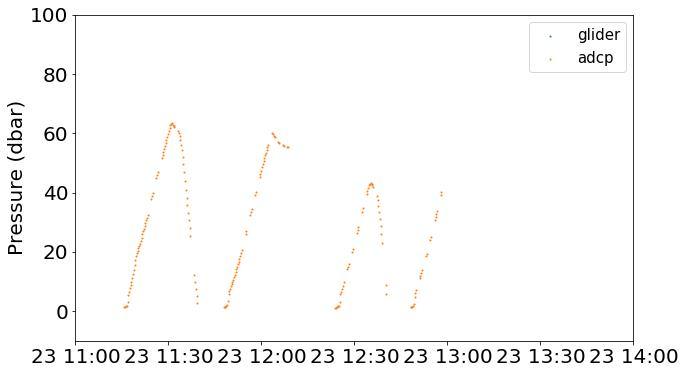

In [133]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(glider_df.index, glider_df.pressure, label='glider', s=1)
ax.scatter(adcp_df.index, adcp_df.pressure_ad, label='adcp', s=1)
ax.set(xlim=[datetime(2018,11,23,11), datetime(2018,11,23,14)],ylim = [-10,100], ylabel='Pressure (dbar)')

ax.legend()
savefig('pressure_glider_vs_adcp')

### Attitude comparison. A mismatch may indicate physcal misalignment of the glider and ADCP or a poor calibration of the accelerometers in either unit.

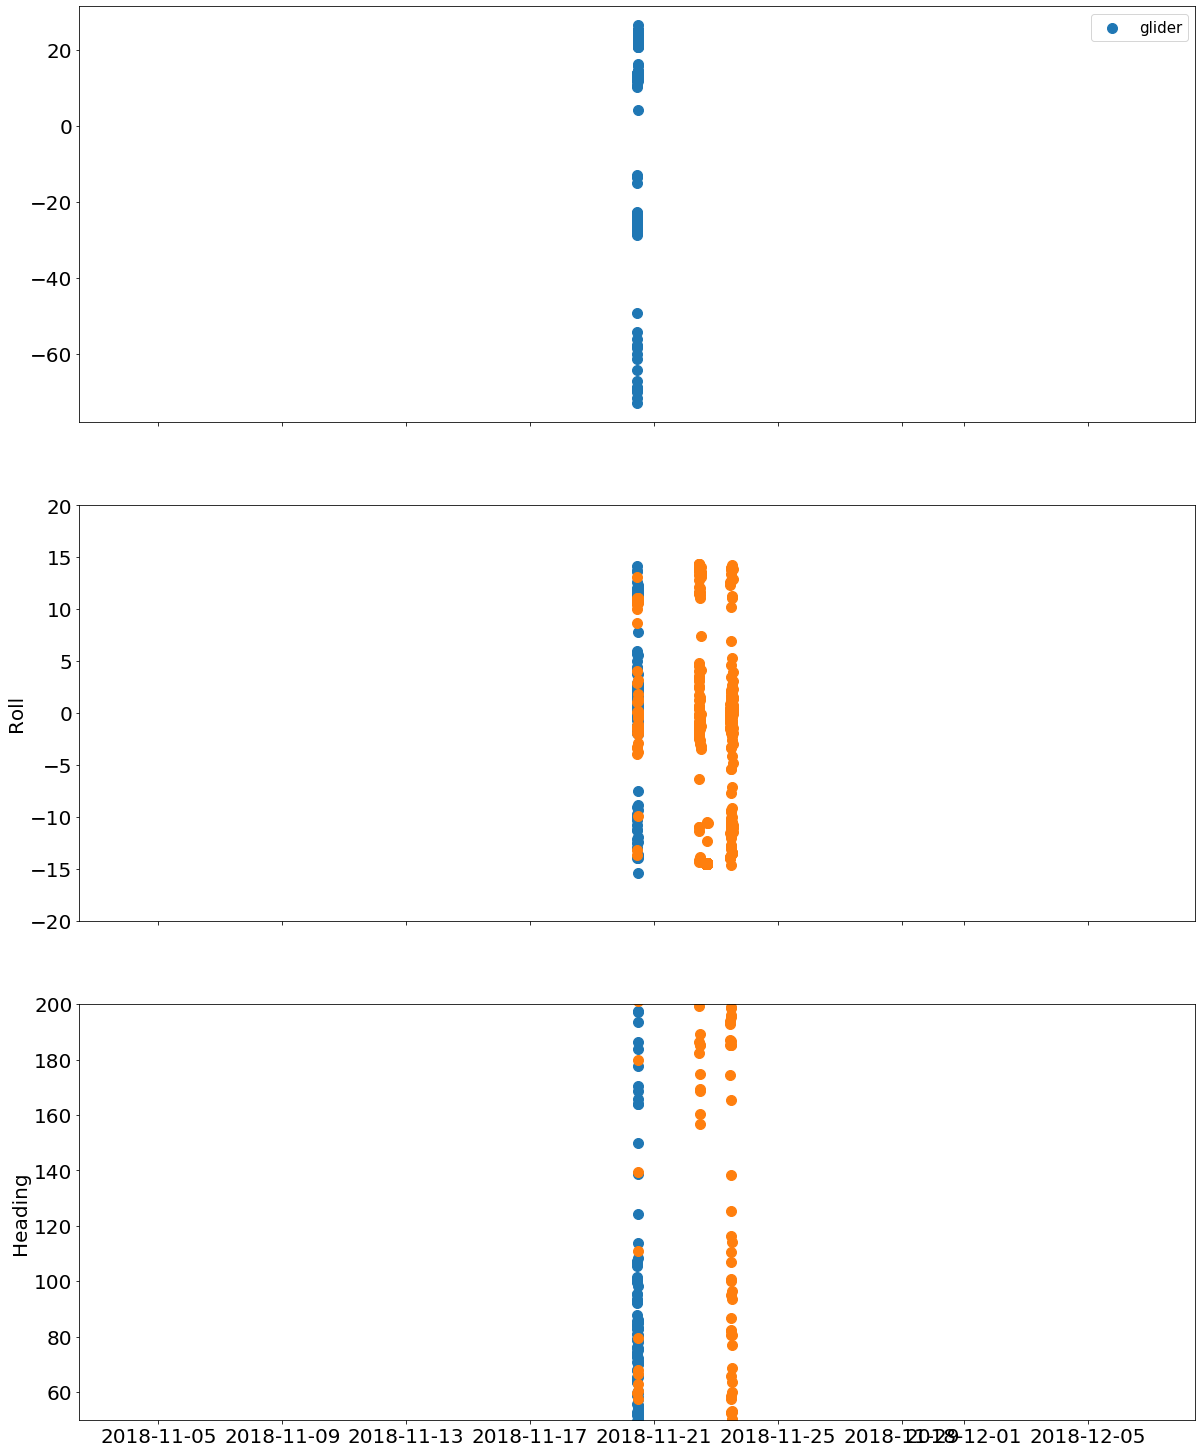

In [130]:
fig, ax = plt.subplots(3,1,figsize=(20,26), sharex=True)
ax = ax.ravel()
ax[0].scatter(glider_df.index, glider_df.pitch, label='glider')
#ax[0].scatter(adcp_df.index, adcp_df.pitch_ad, label='adcp')
#ax[0].set(xlim=[datetime(2020,1,24,0), datetime(2020,1,24,12)], ylim=[-30,30], ylabel='Pitch')
ax[1].scatter(glider_df.index, glider_df.roll)
ax[1].scatter(adcp_df.index, adcp_df.roll_ad)
ax[1].set(ylim=[-20,20], ylabel='Roll')
ax[2].scatter(glider_df.index, glider_df.heading)
ax[2].scatter(adcp_df.index, adcp_df.heading_ad)
ax[2].set(ylim=[50,200], ylabel='Heading')
ax[0].legend();
savefig('attitude_glider_vs_adcp')

In [ ]:
glider_av_df = glider_df.groupby('dive', as_index=False).mean()
glider_av_df

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(16,14), sharex=True)
ax = ax.ravel()
ax[0].scatter(glider_av_df.dive_num, glider_av_df.DAC_u)
ax[1].scatter(glider_av_df.dive_num, glider_av_df.DAC_v)
ax[0].set(ylabel='DAC u $(\mathrm{m\ s^{-1}})$', ylim=[-0.2, 0.2])
ax[1].set(ylabel='DAC v $(\mathrm{m\ s^{-1}})$', xlabel='Dive number', ylim=[-0.2, 0.2])
savefig('DAC_by_dive')

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(16,14), sharex=True)
ax = ax.ravel()
ax[0].scatter(glider_av_df.heading, glider_av_df.DAC_u)
ax[1].scatter(glider_av_df.heading, glider_av_df.DAC_v)
ax[0].set(ylabel='DAC u $(\mathrm{m\ s^{-1}})$', ylim=[-0.2, 0.2])
ax[1].set(ylabel='DAC v $(\mathrm{m\ s^{-1}})$', xlabel='Mean heading', ylim=[-0.2, 0.2], xlim=[0,360])
savefig('DAC_by_heading')

In [ ]:
dive_vel[:,1,0][:-1]

In [ ]:
dive = mission_dict['0041a']
flagger = copy.deepcopy(dive.flag_bad_data)
for cell in range(np.size(flagger,1)):
    flagger[:,cell,:] = flagger[:,3,:]
dive_vel = copy.deepcopy(dive.vel_xyz)
dive_vel[:,1,0][:-1]

In [ ]:
ax[0].scatter(-foo.glider_w_from_p,foo.vel_xyz[:,1,0][:-1], label='x')

In [ ]:
dive_vel[:,cell,0]

In [ ]:
mission_dict['0041b'].flag_bad_data[:,3,:]

In [ ]:
sub_df = asc_df[asc_df.dive_no== 41.0]
sub_df.describe()

In [ ]:
des_df.describe()

In [ ]:
asc_df.describe()

In [ ]:
sub_df = asc_df[asc_df.dive_no== 41.0]
sub_df.describe()asc_df.corr()

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,10), sharey=True)
ax = ax.ravel()
ax[0].scatter(-des_df.u, des_df.w_from_p, s = 0.5, label='Dive')
ax[0].scatter(-asc_df.u, asc_df.w_from_p, s = 0.5, label='Climb')
ax[0].set(xlim=[0, 0.6], ylim=[-0.3, 0.3], xlabel='Glider forward speed from ADCP', ylabel='Vertical speed from pressure')
ax[0].legend()

ax[1].scatter(-des_df.v, des_df.w_from_p, s = 0.5, label='Dive')
ax[1].scatter(-asc_df.v, asc_df.w_from_p, s = 0.5, label='Climb')
ax[1].set(xlim=[-0.2,0.2], ylim=[-0.3, 0.3], xlabel='Glider cross speed from ADCP')
savefig('all_speed_pressure')


In [ ]:
g = sns.jointplot(des_df.u, des_df.w_from_p, height=12, space=0, xlim=(-0.6, 0.0), ylim=(-0.3, -0.04))
savefig('seaborn_den_scat')

In [ ]:
g = sns.jointplot(asc_df.u, asc_df.w_from_p, kind="kde", height=12, space=0, xlim=(-1, 0.2), ylim=(0.06, 0.14))

In [ ]:
asc_df.corr()

Plot the xyz velocites from one dive cycle. Upper panel dive, lower panel climb

In [7]:
foo = mission_dict['0061a']
bar = mission_dict['0061b']

Plot velocities beam by beam

/home/callum/anaconda3/envs/adcp-glider/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


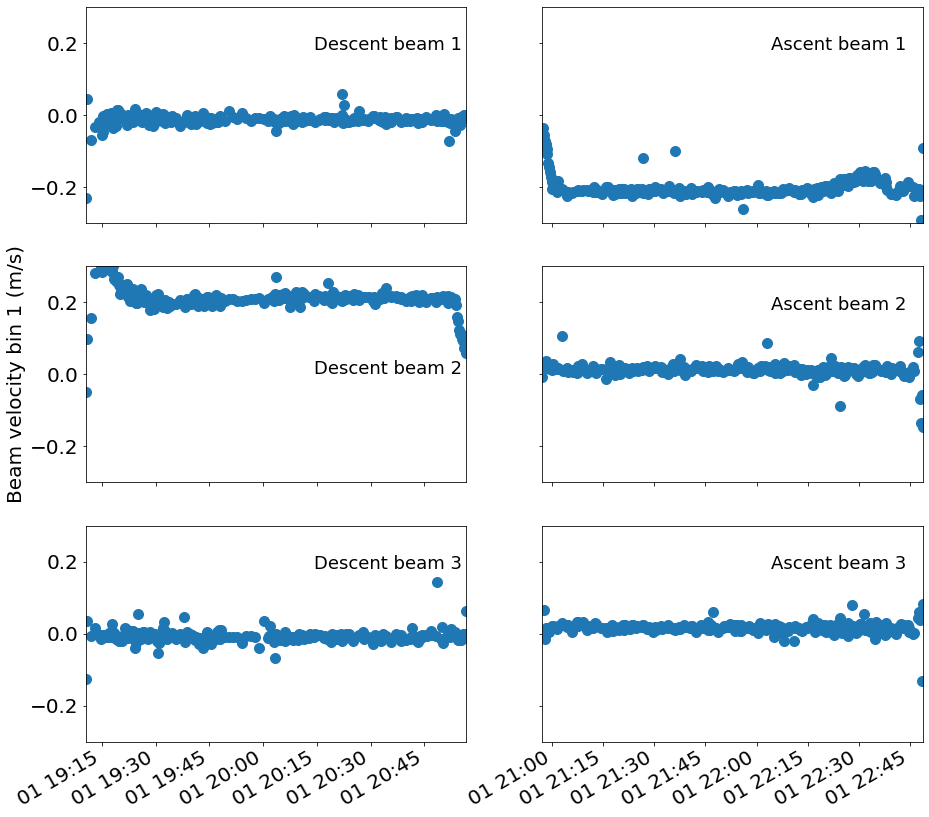

In [8]:
v_lim = 0.3
fig,ax = plt.subplots(3,2,figsize=(15,15), sharex='col', sharey='row')
ax = ax.ravel()
ax[0].scatter(foo.time,foo.vel_beam[:,0,0])#, c = foo.roll, cmap='RdBu', vmin=-5, vmax=5, s = 10)
ax[1].scatter(bar.time,bar.vel_beam[:,0,0])#, c = bar.roll, cmap='RdBu', vmin=-5, vmax=5, s = 10)
ax[2].scatter(foo.time,foo.vel_beam[:,0,1])#, c = foo.roll, cmap='RdBu', vmin=-5, vmax=5, s = 10)
ax[3].scatter(bar.time,bar.vel_beam[:,0,1])#, c = bar.roll, cmap='RdBu', vmin=-5, vmax=5, s = 10)
ax[4].scatter(foo.time,foo.vel_beam[:,0,2])#, c = foo.roll, cmap='RdBu', vmin=-5, vmax=5, s = 10)
ax[5].scatter(bar.time,bar.vel_beam[:,0,2])#, c = bar.roll, cmap='RdBu', vmin=-5, vmax=5, s = 10)

ax[0].set(ylim=[-v_lim, v_lim])
ax[2].set(ylim=[-v_lim, v_lim], ylabel='Beam velocity bin 1 (m/s)')
ax[4].set(xlim=[foo.time[0], foo.time[-1]], ylim=[-v_lim, v_lim])
ax[5].set(xlim=[bar.time[0], bar.time[-1]])

ax[0].text(0.6, 0.8, 'Descent beam 1',transform=ax[0].transAxes)
ax[1].text(0.6, 0.8, 'Ascent beam 1',transform=ax[1].transAxes)
ax[2].text(0.6, 0.5, 'Descent beam 2',transform=ax[2].transAxes)
ax[3].text(0.6, 0.8, 'Ascent beam 2',transform=ax[3].transAxes)
ax[4].text(0.6, 0.8, 'Descent beam 3',transform=ax[4].transAxes)
ax[5].text(0.6, 0.8, 'Ascent beam 3',transform=ax[5].transAxes)
fig.autofmt_xdate()
#savefig('beam_velocities')

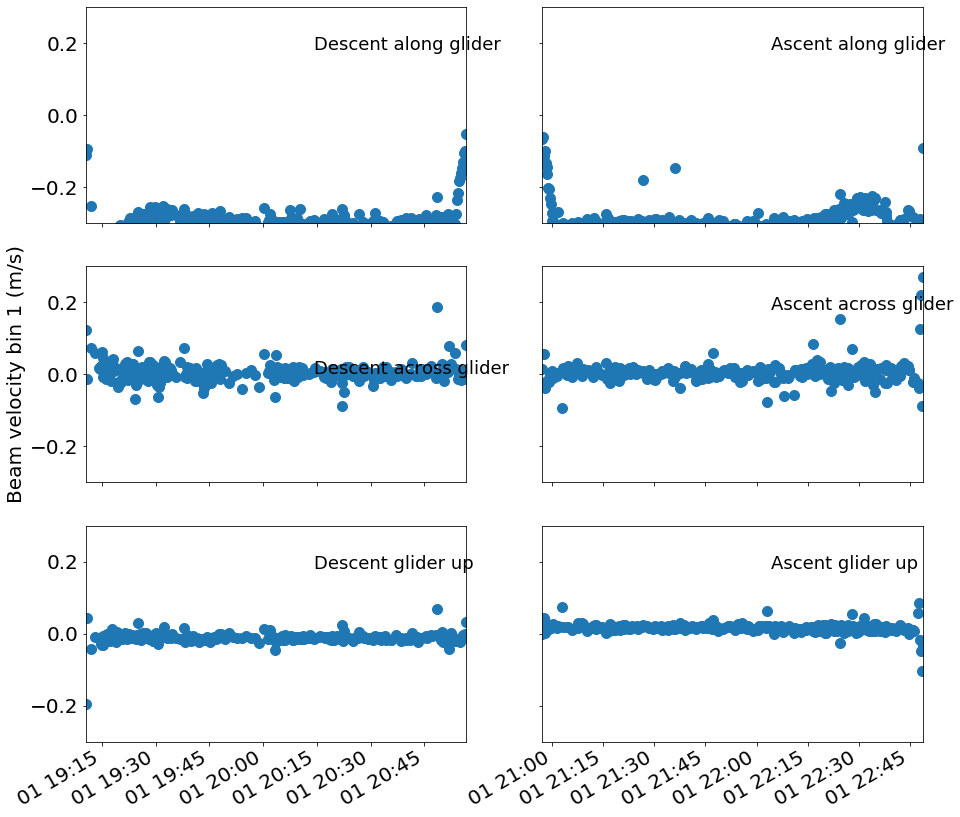

In [13]:
v_lim = 0.3
fig,ax = plt.subplots(3,2,figsize=(15,15), sharex='col', sharey='row')
ax = ax.ravel()
ax[0].scatter(foo.time,foo.vel_xyz[:,0,0])#, c = foo.roll, cmap='RdBu', vmin=-5, vmax=5, s = 10)
ax[1].scatter(bar.time,bar.vel_xyz[:,0,0])#, c = bar.roll, cmap='RdBu', vmin=-5, vmax=5, s = 10)
ax[2].scatter(foo.time,foo.vel_xyz[:,0,1])#, c = foo.roll, cmap='RdBu', vmin=-5, vmax=5, s = 10)
ax[3].scatter(bar.time,bar.vel_xyz[:,0,1])#, c = bar.roll, cmap='RdBu', vmin=-5, vmax=5, s = 10)
ax[4].scatter(foo.time,foo.vel_xyz[:,0,2])#, c = foo.roll, cmap='RdBu', vmin=-5, vmax=5, s = 10)
ax[5].scatter(bar.time,bar.vel_xyz[:,0,2])#, c = bar.roll, cmap='RdBu', vmin=-5, vmax=5, s = 10)

ax[0].set(ylim=[-v_lim, v_lim])
ax[2].set(ylim=[-v_lim, v_lim], ylabel='Beam velocity bin 1 (m/s)')
ax[4].set(xlim=[foo.time[0], foo.time[-1]], ylim=[-v_lim, v_lim])
ax[5].set(xlim=[bar.time[0], bar.time[-1]])

ax[0].text(0.6, 0.8, 'Descent along glider',transform=ax[0].transAxes)
ax[1].text(0.6, 0.8, 'Ascent along glider',transform=ax[1].transAxes)
ax[2].text(0.6, 0.5, 'Descent across glider',transform=ax[2].transAxes)
ax[3].text(0.6, 0.8, 'Ascent across glider',transform=ax[3].transAxes)
ax[4].text(0.6, 0.8, 'Descent glider up',transform=ax[4].transAxes)
ax[5].text(0.6, 0.8, 'Ascent glider up' , transform=ax[5].transAxes)
fig.autofmt_xdate()

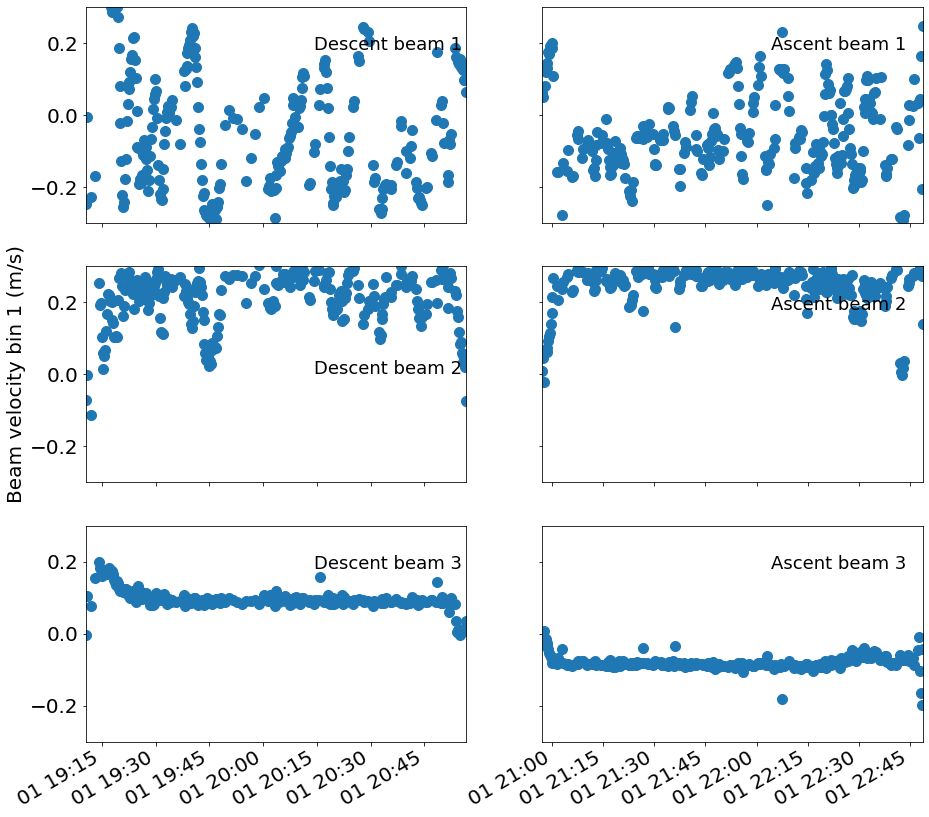

In [14]:
v_lim = 0.3
fig,ax = plt.subplots(3,2,figsize=(15,15), sharex='col', sharey='row')
ax = ax.ravel()
ax[0].scatter(foo.time,foo.vel_enu[:,0,0])#, c = foo.roll, cmap='RdBu', vmin=-5, vmax=5, s = 10)
ax[1].scatter(bar.time,bar.vel_enu[:,0,0])#, c = bar.roll, cmap='RdBu', vmin=-5, vmax=5, s = 10)
ax[2].scatter(foo.time,foo.vel_enu[:,0,1])#, c = foo.roll, cmap='RdBu', vmin=-5, vmax=5, s = 10)
ax[3].scatter(bar.time,bar.vel_enu[:,0,1])#, c = bar.roll, cmap='RdBu', vmin=-5, vmax=5, s = 10)
ax[4].scatter(foo.time,foo.vel_enu[:,0,2])#, c = foo.roll, cmap='RdBu', vmin=-5, vmax=5, s = 10)
ax[5].scatter(bar.time,bar.vel_enu[:,0,2])#, c = bar.roll, cmap='RdBu', vmin=-5, vmax=5, s = 10)

ax[0].set(ylim=[-v_lim, v_lim])
ax[2].set(ylim=[-v_lim, v_lim], ylabel='Beam velocity bin 1 (m/s)')
ax[4].set(xlim=[foo.time[0], foo.time[-1]], ylim=[-v_lim, v_lim])
ax[5].set(xlim=[bar.time[0], bar.time[-1]])

ax[0].text(0.6, 0.8, 'Descent beam 1',transform=ax[0].transAxes)
ax[1].text(0.6, 0.8, 'Ascent beam 1',transform=ax[1].transAxes)
ax[2].text(0.6, 0.5, 'Descent beam 2',transform=ax[2].transAxes)
ax[3].text(0.6, 0.8, 'Ascent beam 2',transform=ax[3].transAxes)
ax[4].text(0.6, 0.8, 'Descent beam 3',transform=ax[4].transAxes)
ax[5].text(0.6, 0.8, 'Ascent beam 3',transform=ax[5].transAxes)
fig.autofmt_xdate()

In [ ]:
sub_df = asc_df[asc_df.dive_no== 41.0]
fig,ax = plt.subplots(figsize=(10,8))
ax.scatter(sub_df.w_from_p, sub_df.u)
#ax.set(xlim=[-0.5, 0.5], ylim=[-0.5, 0.5])

In [ ]:
sub_df

In [ ]:
dive = mission_dict['0041a']
flagger = copy.deepcopy(dive.flag_bad_data)
for cell in range(np.size(flagger,1)):
    flagger[:,cell,:] = flagger[:,3,:]
dive_vel = copy.deepcopy(dive.vel_xyz)
dive_vel[:,1,0][:-1]

In [ ]:
np.round(edgetocentre(foo.vel_xyz[:,1,0]) - des_df.u.values,2)

In [ ]:
des_df.u

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(12,14), sharex=False)
ax = ax.ravel()
ax[0].scatter(-foo.glider_w_from_p,foo.vel_xyz[:,1,0][:-1], label='x')
ax[0].scatter(-foo.glider_w_from_p,foo.vel_xyz[:,1,1][:-1], label='y')
#ax[0].scatter(-foo.glider_w_from_p,foo.vel_xyz[:,1,2][:-1], label='z')
ax[0].set(xlim=[0,0.2], ylim=[-0.4,0.4],ylabel='xyz water velocity from ADCP m/s')
ax[0].legend()
ax[1].scatter(-bar.glider_w_from_p,bar.vel_xyz[:,1,0][:-1], label='x')
ax[1].scatter(-bar.glider_w_from_p,bar.vel_xyz[:,1,1][:-1], label='y')
#ax[1].scatter(-bar.glider_w_from_p,bar.vel_xyz[:,1,2][:-1], label='z')
ax[1].set(xlim=[-0.25,0.], ylim=[-0.4,0.4], xlabel='w from pressure m/s')
#savefig('xyz_vel_dive41')

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(12,14), sharex=False)
ax = ax.ravel()
ax[0].scatter(tl, -foo.measurement_z, c=foo.cor_beam[:,:,2],  label='x')
#ax[0].scatter(-foo.glider_w_from_p,foo.vel_xyz[:,1,1][:-1], label='y')
#ax[0].scatter(-foo.glider_w_from_p,foo.vel_xyz[:,1,2][:-1], label='z')
#ax[0].set(xlim=[0,0.2], ylim=[-0.4,0.4],ylabel='xyz water velocity from ADCP m/s')
ax[0].legend()
ax[1].scatter(-bar.glider_w_from_p,bar.vel_xyz[:,1,0][:-1], label='x')
ax[1].scatter(-bar.glider_w_from_p,bar.vel_xyz[:,1,1][:-1], label='y')
#ax[1].scatter(-bar.glider_w_from_p,bar.vel_xyz[:,1,2][:-1], label='z')
ax[1].set(xlim=[-0.25,0.], ylim=[-0.4,0.4], xlabel='w from pressure m/s')
#savefig('xyz_vel_dive41')

In [ ]:
foo.cor_beam[:,:,2]
foo.measurement_z
tl = np.transpose(np.tile(foo.time, (15,1)))
tl2 = np.transpose(np.tile(bar.time, (15,1)))

In [ ]:
fig, ax = plt.subplots(figsize=(12,14))

mp0 = ax.scatter(tl, foo.measurement_z, c=foo.cor_beam[:,:,2], vmin=0, vmax=100,cmap='RdBu',s=10)
ax.scatter(tl2, bar.measurement_z, c=bar.cor_beam[:,:,2], vmin=0, vmax=100,cmap='RdBu',s=10)
fig.colorbar(ax = ax,mappable=mp0, label='Ping correlation %')
ax.set(xlim=[tl[0,0], tl2[-1,-1]], ylabel='z (m)')
savefig('correlation')

In [ ]:
fig, ax = plt.subplots(figsize=(12,14))

mp0 = ax.scatter(tl, foo.measurement_z, c=foo.beam_miss, vmin=0, vmax=2,cmap='RdBu_r',s=10)
ax.scatter(tl2, bar.measurement_z, c=bar.beam_miss, vmin=0, vmax=2,cmap='RdBu_r',s=10)
fig.colorbar(ax = ax,mappable=mp0, label='Beam miss (m)')
ax.set(xlim=[tl[0,0], tl2[-1,-1]], ylabel='z (m)')
savefig('beam_miss')

In [ ]:
foo.beam_miss

In [ ]:
np.shape(foo.measurement_z)

As above for enu velocites

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(12,14), sharex=False)
ax = ax.ravel()
ax[0].scatter(-foo.glider_w_from_p,foo.vel_enu[:,0,0][:-1], label='x')
ax[0].scatter(-foo.glider_w_from_p,foo.vel_enu[:,0,1][:-1], label='y')
#ax[0].scatter(-foo.glider_w_from_p,foo.vel_enu[:,0,2][:-1], label='z')
ax[0].set(xlim=[0,0.2], ylim=[-0.4,0.4],ylabel='water velocity from ADCP m/s')
ax[0].legend()
ax[1].scatter(-bar.glider_w_from_p,bar.vel_enu[:,0,0][:-1], label='x')
ax[1].scatter(-bar.glider_w_from_p,bar.vel_enu[:,0,1][:-1], label='y')
#ax[1].scatter(-bar.glider_w_from_p,bar.vel_enu[:,0,2][:-1], label='z')
ax[1].set(xlim=[-0.25,0.], ylim=[-0.4,0.4], xlabel='w from pressure m/s')
savefig('enu_vel_dive41')

In [ ]:
all_the_shear = np.empty((len(mission_dict),100,3))
all_the_amp = np.empty((len(mission_dict),100,3))

in_bin = np.empty((len(mission_dict), 100))
for i, dive in enumerate(mission_dict.keys()):
    all_the_shear[i,:,:] = mission_dict[dive].vel_referenced
    in_bin[i,:] = mission_dict[dive].no_in_bin
    all_the_amp[i,:] = mission_dict[dive].amp_binned


In [ ]:
np.shape(all_the_amp)

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
nos = ax.pcolor(np.arange(0,len(overview.index)/2,0.5), np.arange(-1000,10,10),np.transpose(np.nanmean(all_the_amp,2)),vmin=30, vmax=40, cmap='RdBu')
ax.set(ylim=[-760,0], ylabel='z (m)', xlabel='Dive number', label='return_amp')
fig.colorbar(mappable=nos,ax=ax)
savefig('return_amp')

Check how many adcp velocity shear measurements were used in each cell of the velocity profile

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
nos = ax.pcolor(np.arange(0,len(overview.index)/2,0.5), np.arange(-1000,10,10),np.transpose(in_bin), vmin=0, vmax=100, cmap='viridis')
ax.set(ylim=[-760,0], ylabel='z (m)', xlabel='Dive number')
fig.colorbar(mappable=nos,ax=ax, label='number of shear estimates per bin', extend='max')
savefig('vels_per_10m_bin')

Plot the shear profiles

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(15,30), sharex=True)
ax = ax.ravel()
ax[0].pcolor(np.transpose(all_the_shear[201:250,:,0]), cmap='RdBu_r', vmin=-0.5, vmax=0.5)
ax[1].pcolor(np.transpose(all_the_shear[201:250,:,1]), cmap='RdBu_r', vmin=-0.5, vmax=0.5)

-------------------
# Rough stuff